# ガウス過程

## 0.設定

In [94]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Random
using Plots.PlotMeasures; px

0.254mm

In [13]:
# 現在(2021/12/02) inv()でstack overflow が発生するので暫定対処
# 環境：Julia V1.6.4
BLAS.set_num_threads(1)

In [3]:
#シード固定とプログラムで使う型を決める
rng = MersenneTwister(20220105)
FT = Float32

Float32

## 1.問題設定

予測する関数を設定

ガウス関数2つの重ね合わせ
$$
f(x) = a_1 \exp \left[ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right] + a_2 \exp \left[ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right]
$$

In [135]:
function exact(x, a₁=0.4, a₂=2.0, μ₁=0.3, μ₂=-0.6, σ₁=0.5, σ₂=0.2)
    ϕ = a₁ .* exp.(-(x .-μ₁).^2 ./(2*σ₁^2)) + a₂ .* exp.(-(x .- μ₂).^2 ./(2*σ₂^2))
end

exact (generic function with 7 methods)

In [68]:
function make_data(FT=Float32; N=30, σₜ = 0.05, lₓ = 1)
    @eval N = $(N)
    @eval σₜ = $(σₜ)
    @eval lₓ = $(lₓ)
    # x_data: [-lₓ, lₓ)の一様分布
    # t_data: exact + 平均0, 標準偏差σₜの正規分布
    @eval x_data = Vector{$(FT)}((rand(rng, $(FT), N) .-0.5) .*(2*lₓ))
    @eval t_data = Vector{$(FT)}(exact.(x_data) .+ randn(rng, $(FT), N) .*σₜ)
    @eval x_dense = Vector{$(FT)}([i for i=-lₓ:2lₓ/50:lₓ])
    @eval t_dense = exact.(x_dense)
end

make_data (generic function with 2 methods)

In [69]:
make_data();

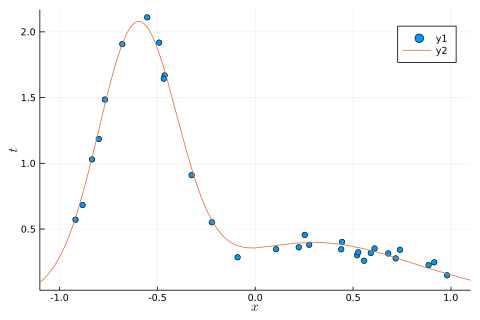

In [70]:
scatter(x_data, t_data, dpi=20, xlabel=L"x", ylabel=L"t")
plot!(exact, xlim=(-1.1,1.1))

## 2.ガウス過程の実装

In [14]:
"""
theta3 = β⁻¹ : 共分散行列のノイズ
"""
function gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
    # repeat(x_data, 1, size(t_data)[1]) - repeat(t_data', size(x_data)[1])
    # .でキャスト、'で転置。Vector{N} - Matrix{1×M} = Matrix{N×M}
    x_diff = x1 .- x2' 
    @assert size(x_diff) == (size(x1)[1], size(x2)[1])
    kmat = θ₁ .* exp.(-(x_diff.^2) ./ θ₂) #アダマール積＆要素ごとのexp
    if x1==x2
        kmat += θ₃*I
    end
    return kmat
end

gauss_kernel

In [15]:
"""
 x: D次元空間
xtrain = Xₙ : x内のn個の測定点 Vector{n}
ytrain = tₙ : Xₙにおける測定値 Matrix{1×n}
xtest =  xₙ₊₁: 新しい測定点xₙ₊₁ Real or Vector{m}
K = Cₙ : 共分散行列 Matrix{n×n}
k_test = k : xₙとxₙ₊₁の相関? Vector{n} or Matrix{n×m}
k_diag = c : Real or 
"""
function gauss_process(Xₙ, tₙ, xₙ₊₁, func_kernel)
    # @show size(Xₙ)
    Cₙ⁻¹ = inv(func_kernel(Xₙ, Xₙ))
    k = func_kernel(Xₙ, xₙ₊₁)
    c = func_kernel(xₙ₊₁, xₙ₊₁)
    μ = k' * Cₙ⁻¹ * tₙ
    σ² = diag(c - k' * Cₙ⁻¹ * k).^0.5
    return μ, σ²
end

gauss_process

In [88]:
function myplot(x_data, t_data, x_dense, μₘ, σₘ, label=""; dpi=20)
    param = Dict(:dpi=>dpi, :legend=>:outerbottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = scatter(x_data, t_data, label="data $(label)", shape=:+, markercolor=:deepskyblue; param...)
    plot!(exact, linecolor=:lime, label="model(unknown)")
    plot!(x_dense, μₘ, ribbon=σₘ, label="predict", fillalpha=0.1, color=:tomato) 
    return plt
end

myplot (generic function with 5 methods)

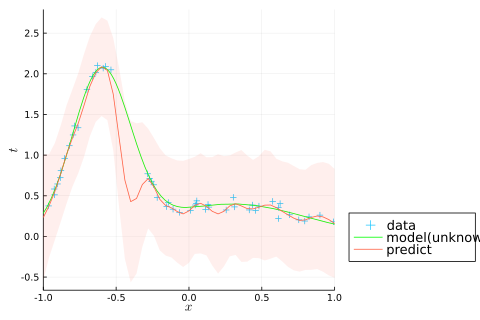

In [89]:
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, 1, 0.01, 0.1)
μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
σₘ = σₘ² .^0.5
myplot(x_data, t_data, x_dense, μₘ, σₘ)

## 3.サンプル

繰り返し用関数

In [93]:
function myplots(plts; figsize=(1000, 1000))
    plot(plts..., layout=(size(plts)[1], 1), size=figsize, right_margin=50px, dpi=20)
end

myplots (generic function with 1 method)

In [96]:
function make_data_rtn(FT=Float32; N=30, σₜ = 0.1, lₓ = 1)
    x_data = Vector{FT}((rand(rng, FT, N) .-0.5) .*(2*lₓ))
    t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, N) .*σₜ)
    x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
    t_dense = exact.(x_dense)
    return (x_data, t_data, x_dense, t_dense)
end

make_data_rtn (generic function with 2 methods)

### 3.1.データ点を増やす

┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_4_2.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_4_2.gif")
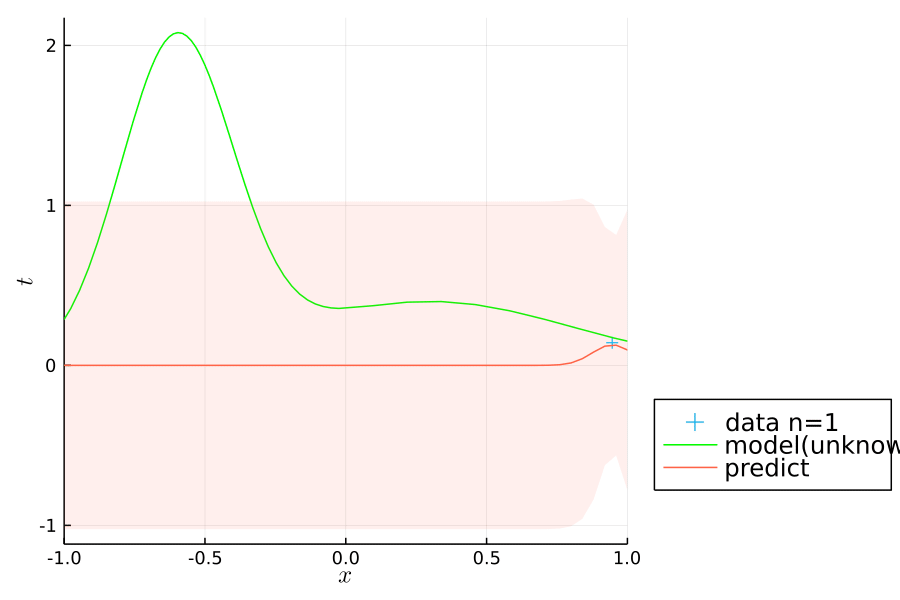

In [92]:
plts = []
pltflg = [1, 5, 10, 50]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense);
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, 1, 0.01, 0.1)

anim = @animate for i in 1:1:50
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    plt = myplot(x_data, t_data, x_dense, μₘ, σₘ, "n=$(i)", dpi=150)
    push!(x_data, (rand(rng, FT) .-0.5) .*(2*lₓ))
    push!(t_data, exact.(x_data[end]) .+ randn(rng, FT) .*σₜ)
    if i in pltflg
       push!(plts, plt) 
    end
end


gif(anim, "report_6.gif", fps=2)

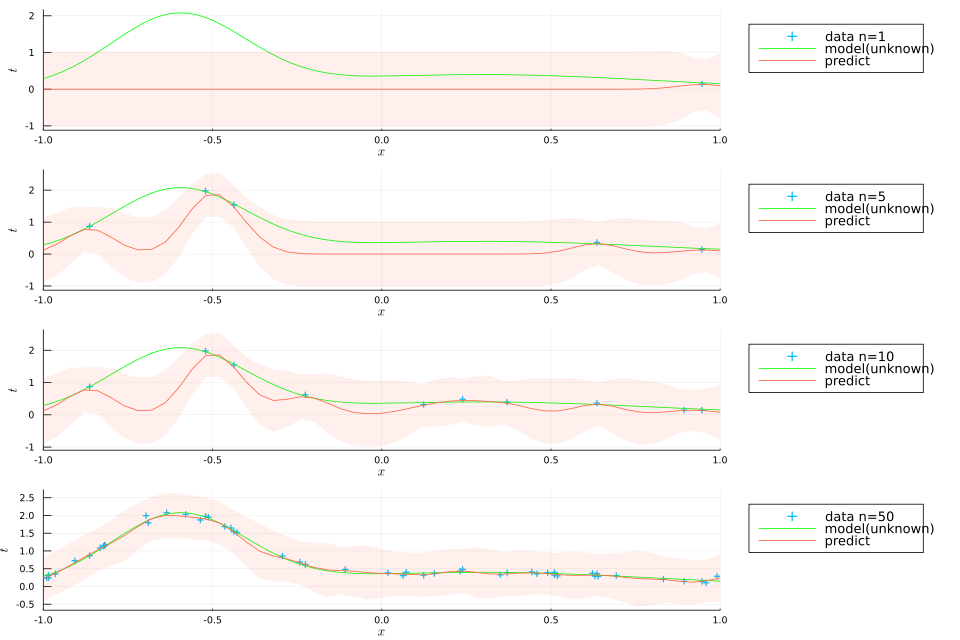

In [95]:
myplots(plts, figsize=(1200, 800))

### 3.2.パラメータを変える

In [112]:
x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)

(Float32[0.025058985, 0.4628756, -0.98351216, 0.88189125, 0.50541854, -0.65418625, -0.49608564, -0.017758608, -0.36293578, 0.24830818, -0.5192685, -0.29594493, -0.97829103, 0.70581126, -0.2104578, 0.49776244, 0.61967325, -0.36875248, 0.9478998, 0.30473256], Float32[0.4127396, 0.3702015, 0.29096946, 0.01664562, 0.4018923, 2.0153885, 1.8122754, 0.4031235, 1.3249234, 0.42092904, 1.9203799, 0.74681574, 0.32079202, 0.35911474, 0.5160271, 0.74205923, 0.42610392, 1.0626576, 0.21630913, 0.42961973], Float32[-1.0, -0.96, -0.92, -0.88, -0.84, -0.8, -0.76, -0.72, -0.68, -0.64  …  0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0], [0.28428954836706516, 0.4125117748508191, 0.5764567775104921, 0.7753187977467286, 1.0032378770031112, 1.2486298922392827, 1.494576033634292, 1.7204723968086681, 1.9048285541047334, 2.0287216141414124  …  0.3174323087746409, 0.29966480842288973, 0.2810870763320334, 0.2619790569734883, 0.24261225814652096, 0.22324383482411522, 0.20411112137877635, 0.185427599324223

### $\theta_1$

θ1 = 0.01
θ1 = 1.0
θ1 = 10.0
θ1 = 1000.0


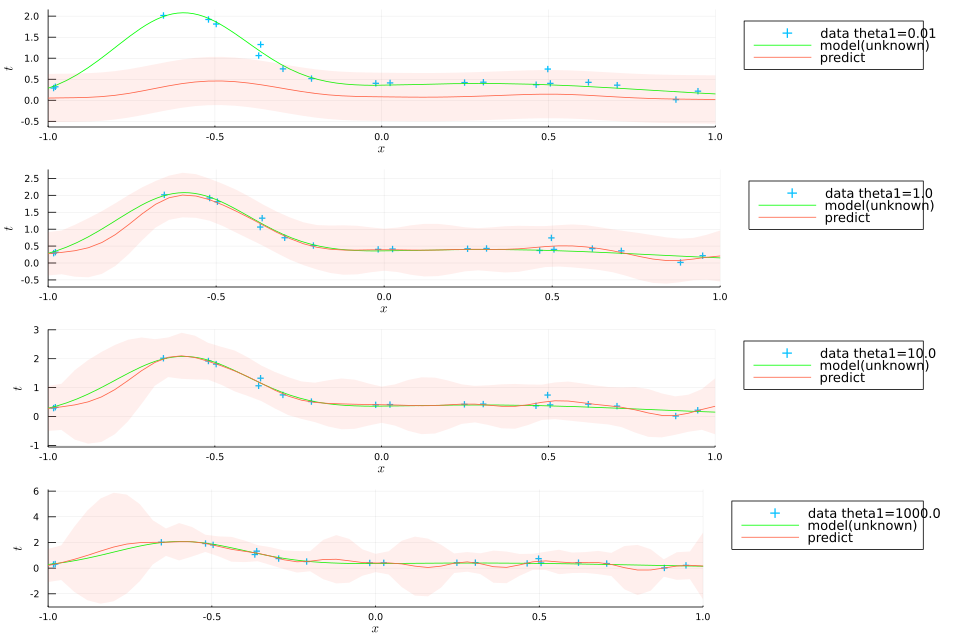

In [131]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for θ1 in [0.01, 1, 10, 1000]
    @show θ1
    gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ1, 0.03, 0.1)
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    plt = myplot(x_data, t_data, x_dense, μₘ, σₘ, "theta1=$(θ1)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

### $\theta_2$

θ2 = 0.0001
θ2 = 0.01
θ2 = 0.1
θ2 = 1.0


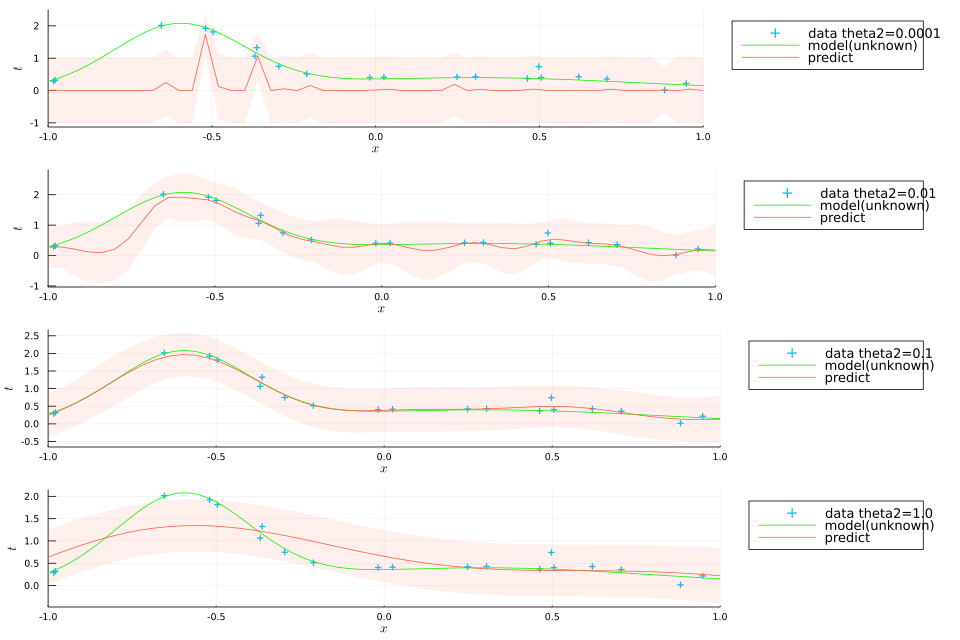

In [132]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for θ2 in [0.0001, 0.01, 0.1, 1]
    @show θ2
    gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, 1, θ2, 0.1)
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    plt = myplot(x_data, t_data, x_dense, μₘ, σₘ, "theta2=$(θ2)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

### $\beta$
$\beta$ですが、コード上では$\theta_3$として実装しています。

θ3 = 0.0001
θ3 = 0.1
θ3 = 1.0
θ3 = 10.0


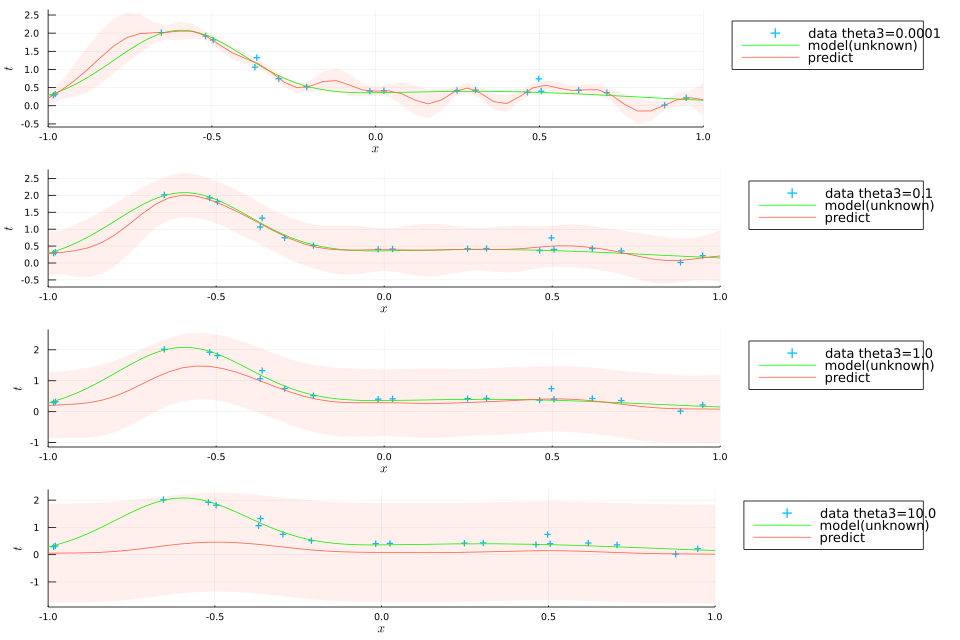

In [134]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for θ3 in [0.0001, 0.1, 1, 10]
    @show θ3
    gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, 1, 0.03, θ3)
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    plt = myplot(x_data, t_data, x_dense, μₘ, σₘ, "theta3=$(θ3)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))